# 1-1: 데이터 로드 + EDA

IEEE-CIS Fraud Detection 데이터를 탐색하고 분석합니다.

## 학습 목표
1. **데이터 이해** - Transaction + Identity 테이블 구조
2. **불균형 데이터** - 사기 비율 ~3.5% 확인
3. **결측치 분석** - 처리 전략 수립
4. **시간 기반 분할** - Data Leakage 방지

## 예상 시간
약 3시간

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings('ignore')

# 경로 설정
DATA_RAW = Path('../../data/raw')
DATA_PROCESSED = Path('../../data/processed')
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print("패키지 로드 완료")

패키지 로드 완료


---
## 1. 데이터 로드

### 1-1. IEEE-CIS 데이터셋 구조

**두 개의 테이블:**

| 테이블 | 설명 | 주요 컬럼 |
|--------|------|----------|
| Transaction | 거래 정보 | TransactionID, TransactionAmt, ProductCD, card1~6 |
| Identity | 기기/브라우저 정보 | TransactionID, DeviceType, DeviceInfo, id_01~38 |

**병합 방법:**
- `TransactionID`로 LEFT JOIN
- Identity가 없는 거래도 있음 (결측 발생)

In [6]:
%%time
# 📚 데이터 로드
print("데이터 로드 중...")

train_transaction = pd.read_csv(DATA_RAW / 'train_transaction.csv')
train_identity = pd.read_csv(DATA_RAW / 'train_identity.csv')

print(f"train_transaction: {train_transaction.shape}")
print(f"train_identity: {train_identity.shape}")

데이터 로드 중...
train_transaction: (590540, 394)
train_identity: (144233, 41)
CPU times: total: 14.4 s
Wall time: 14.9 s


In [7]:
# 📚 데이터 병합 (LEFT JOIN)
df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

print(f"병합 후: {df.shape}")
print(f"컬럼 수: {len(df.columns)}")
print(f"\nIdentity 매칭률: {train_identity.shape[0] / train_transaction.shape[0]:.1%}")

병합 후: (590540, 434)
컬럼 수: 434

Identity 매칭률: 24.4%


In [8]:
# 📚 메모리 사용량 확인
memory_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f"메모리 사용량: {memory_mb:.1f} MB")

메모리 사용량: 2567.1 MB


---
## 2. 기본 EDA

In [9]:
# 📚 기본 정보
print("=" * 60)
print("데이터 기본 정보")
print("=" * 60)
print(f"\n행 수: {len(df):,}")
print(f"컬럼 수: {len(df.columns)}")
print(f"\n타겟 (isFraud) 분포:")
print(df['isFraud'].value_counts())
print(f"\n사기 비율: {df['isFraud'].mean():.2%}")

데이터 기본 정보

행 수: 590,540
컬럼 수: 434

타겟 (isFraud) 분포:
isFraud
0    569877
1     20663
Name: count, dtype: int64

사기 비율: 3.50%


In [10]:
# 📚 컬럼 타입별 분류
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"수치형 컬럼: {len(numeric_cols)}개")
print(f"범주형 컬럼: {len(categorical_cols)}개")
print(f"\n범주형 컬럼 목록:")
print(categorical_cols)

수치형 컬럼: 403개
범주형 컬럼: 31개

범주형 컬럼 목록:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [11]:
# 📚 주요 수치형 컬럼 통계
key_numeric = ['TransactionAmt', 'TransactionDT', 'card1', 'card2', 'card3', 'card5']
df[key_numeric].describe()

,TransactionAmt,TransactionDT,card1,card2,card3,card5
count,590540.000000,5.905400e+05,590540.000000,581607.000000,588975.000000,586281.000000
mean,135.027176,7.372311e+06,9898.734658,362.555488,153.194925,199.278897
std,239.162522,4.617224e+06,4901.170153,157.793246,11.336444,41.244453
min,0.251000,8.640000e+04,1000.000000,100.000000,100.000000,100.000000
25%,43.321000,3.027058e+06,6019.000000,214.000000,150.000000,166.000000
50%,68.769000,7.306528e+06,9678.000000,361.000000,150.000000,226.000000
75%,125.000000,1.124662e+07,14184.000000,512.000000,150.000000,226.000000
max,31937.391000,1.581113e+07,18396.000000,600.000000,231.000000,237.000000


---
## 3. 타겟 불균형 분석

### 3-1. 왜 불균형이 문제인가?

**문제:**
- 사기 비율 ~3.5%
- 모델이 "전부 정상"이라고 예측해도 정확도 96.5%
- **Accuracy가 무의미!**

**해결책:**
- 평가 지표: AUC-ROC, PR-AUC, F1
- 모델 학습: class_weight, scale_pos_weight

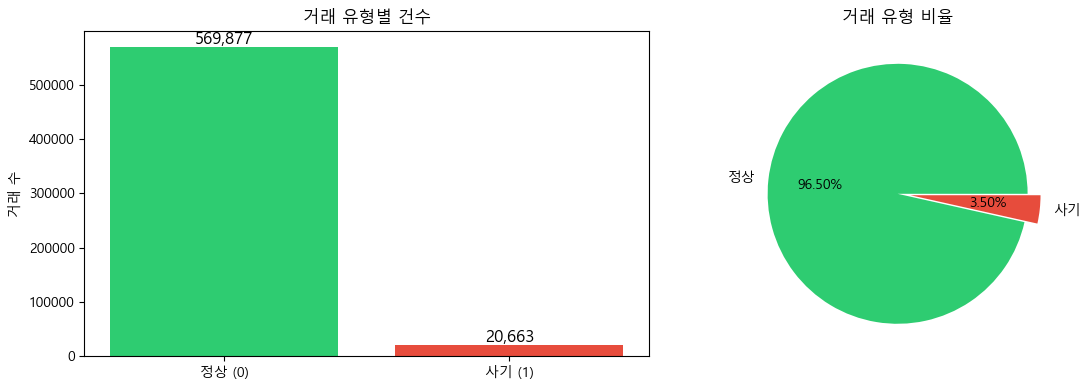


불균형 비율: 1 : 28


In [12]:
# 📚 타겟 불균형 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 막대 그래프
fraud_counts = df['isFraud'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['정상 (0)', '사기 (1)'], fraud_counts.values, color=colors)
axes[0].set_ylabel('거래 수')
axes[0].set_title('거래 유형별 건수')

for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center', fontsize=12)

# 파이 차트
axes[1].pie(fraud_counts.values, labels=['정상', '사기'], autopct='%1.2f%%',
            colors=colors, explode=[0, 0.1])
axes[1].set_title('거래 유형 비율')

plt.tight_layout()
plt.show()

print(f"\n불균형 비율: 1 : {fraud_counts[0] / fraud_counts[1]:.0f}")

---
## 4. 결측치 분석

In [13]:
# 📚 결측치 비율 계산
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print(f"결측치 있는 컬럼: {len(missing_pct)}개 / {len(df.columns)}개")
print(f"\nTop 20 결측 컬럼:")
print(missing_pct.head(20).to_string())

결측치 있는 컬럼: 414개 / 434개

Top 20 결측 컬럼:
id_24    99.196159
id_25    99.130965
id_07    99.127070
id_08    99.127070
id_21    99.126393
id_26    99.125715
id_27    99.124699
id_23    99.124699
id_22    99.124699
dist2    93.628374
D7       93.409930
id_18    92.360721
D13      89.509263
D14      89.469469
D12      89.041047
id_04    88.768923
id_03    88.768923
D6       87.606767
id_33    87.589494
id_09    87.312290


In [14]:
# 📚 결측 비율 구간별 분류
missing_bins = pd.cut(missing_pct, bins=[0, 10, 30, 50, 70, 100], 
                      labels=['0-10%', '10-30%', '30-50%', '50-70%', '70-100%'])
missing_dist = missing_bins.value_counts().sort_index()

print("결측 비율별 컬럼 수:")
print(missing_dist.to_string())

결측 비율별 컬럼 수:
0-10%       92
10-30%      90
30-50%      18
50-70%       6
70-100%    208


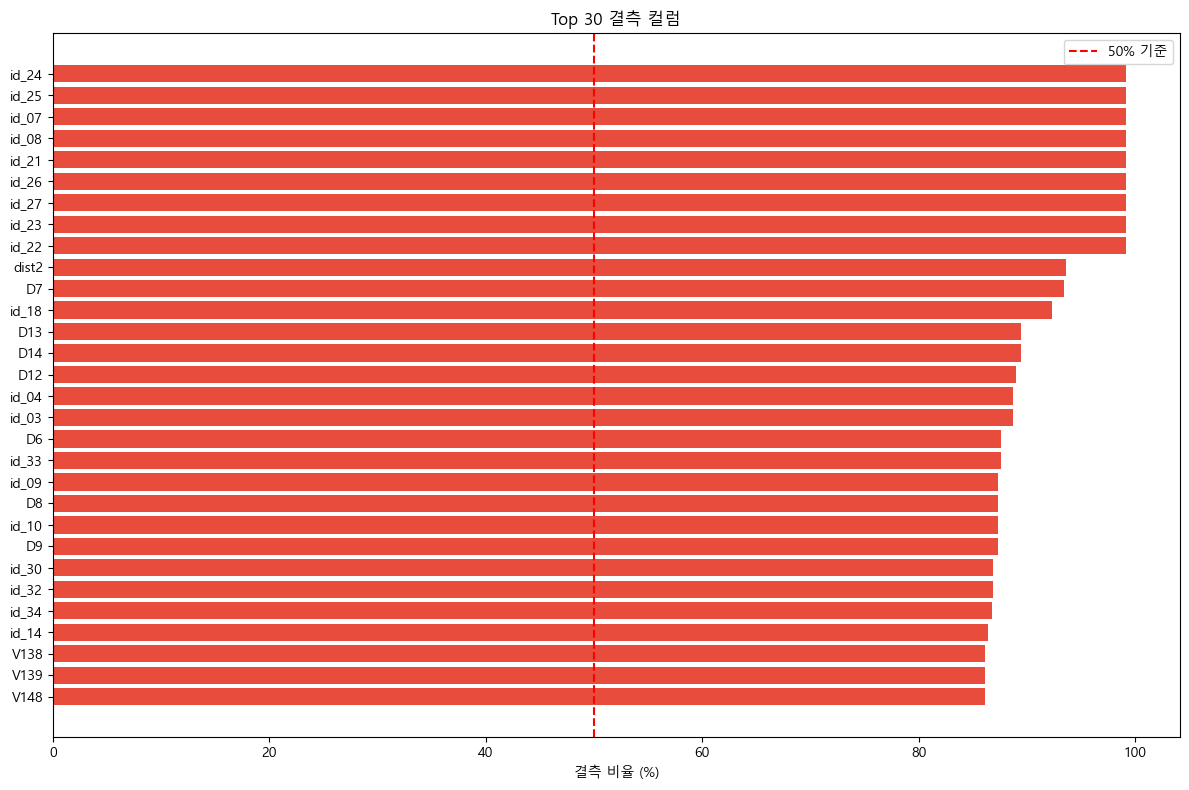

In [15]:
# 📚 결측 비율 시각화 (Top 30)
plt.figure(figsize=(12, 8))
missing_top30 = missing_pct.head(30)
colors = ['#e74c3c' if x > 50 else '#f39c12' if x > 30 else '#3498db' for x in missing_top30]

plt.barh(range(len(missing_top30)), missing_top30.values, color=colors)
plt.yticks(range(len(missing_top30)), missing_top30.index)
plt.xlabel('결측 비율 (%)')
plt.title('Top 30 결측 컬럼')
plt.axvline(x=50, color='red', linestyle='--', label='50% 기준')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 4-1. 결측치 처리 전략

| 결측 비율 | 전략 | 이유 |
|-----------|------|------|
| 70% 이상 | 삭제 고려 | 정보 가치 낮음 |
| 30~70% | 결측 자체가 피처 | `_isna` 컬럼 생성 |
| 30% 미만 | 대체 | 중앙값/최빈값 |

**XGBoost 장점:**
- 결측치 자동 처리
- 별도 대체 없이도 학습 가능

---
## 5. 피처 탐색

### 5-1. TransactionAmt (거래 금액)

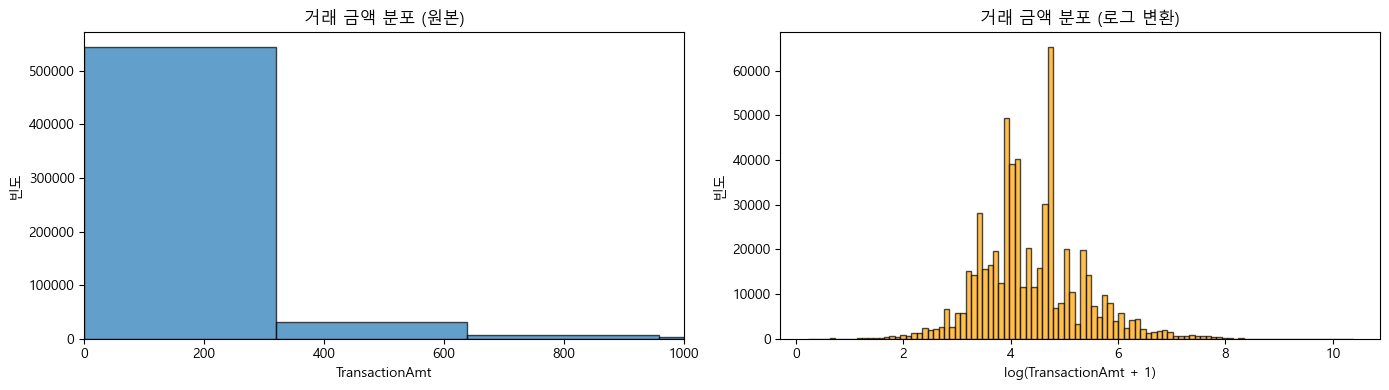

금액 통계:
  최소: $0.25
  최대: $31,937.39
  평균: $135.03
  중앙값: $68.77


In [16]:
# 📚 거래 금액 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 원본 분포
axes[0].hist(df['TransactionAmt'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('TransactionAmt')
axes[0].set_ylabel('빈도')
axes[0].set_title('거래 금액 분포 (원본)')
axes[0].set_xlim(0, 1000)  # 대부분의 거래가 1000 이하

# 로그 변환
axes[1].hist(np.log1p(df['TransactionAmt']), bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('log(TransactionAmt + 1)')
axes[1].set_ylabel('빈도')
axes[1].set_title('거래 금액 분포 (로그 변환)')

plt.tight_layout()
plt.show()

print(f"금액 통계:")
print(f"  최소: ${df['TransactionAmt'].min():.2f}")
print(f"  최대: ${df['TransactionAmt'].max():,.2f}")
print(f"  평균: ${df['TransactionAmt'].mean():.2f}")
print(f"  중앙값: ${df['TransactionAmt'].median():.2f}")

### 5-2. TransactionDT (시간)

In [17]:
# 📚 시간 변환
# TransactionDT는 특정 시점 기준 초(seconds) 단위
# 시간, 요일 등으로 변환

START_DATE = '2017-12-01'  # 추정 시작일
df['datetime'] = pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['day'] = df['datetime'].dt.day

print("시간 변환 완료")
print(f"기간: {df['datetime'].min()} ~ {df['datetime'].max()}")
print(f"총 일수: {(df['datetime'].max() - df['datetime'].min()).days}일")

시간 변환 완료
기간: 2017-12-02 00:00:00 ~ 2018-06-01 23:58:51
총 일수: 181일


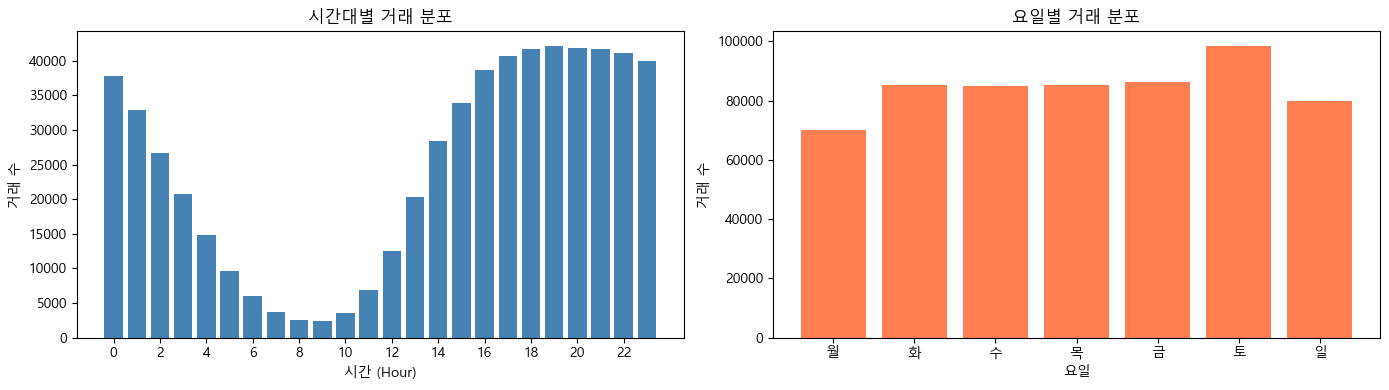

In [18]:
# 📚 시간대별 거래 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 시간대별
hour_counts = df.groupby('hour').size()
axes[0].bar(hour_counts.index, hour_counts.values, color='steelblue')
axes[0].set_xlabel('시간 (Hour)')
axes[0].set_ylabel('거래 수')
axes[0].set_title('시간대별 거래 분포')
axes[0].set_xticks(range(0, 24, 2))

# 요일별
dow_labels = ['월', '화', '수', '목', '금', '토', '일']
dow_counts = df.groupby('dayofweek').size()
axes[1].bar(dow_labels, dow_counts.values, color='coral')
axes[1].set_xlabel('요일')
axes[1].set_ylabel('거래 수')
axes[1].set_title('요일별 거래 분포')

plt.tight_layout()
plt.show()

### 5-3. ProductCD (상품 카테고리)

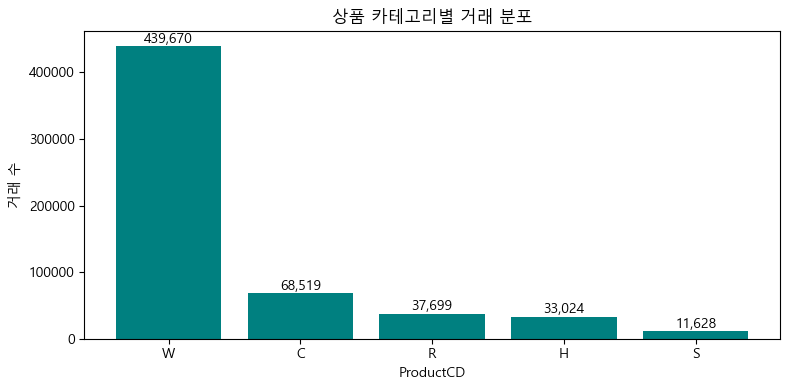

In [19]:
# 📚 상품 카테고리별 분포
product_counts = df['ProductCD'].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(product_counts.index, product_counts.values, color='teal')
plt.xlabel('ProductCD')
plt.ylabel('거래 수')
plt.title('상품 카테고리별 거래 분포')

for i, v in enumerate(product_counts.values):
    plt.text(i, v + 5000, f'{v:,}', ha='center')

plt.tight_layout()
plt.show()

---
## 6. 타겟별 분석

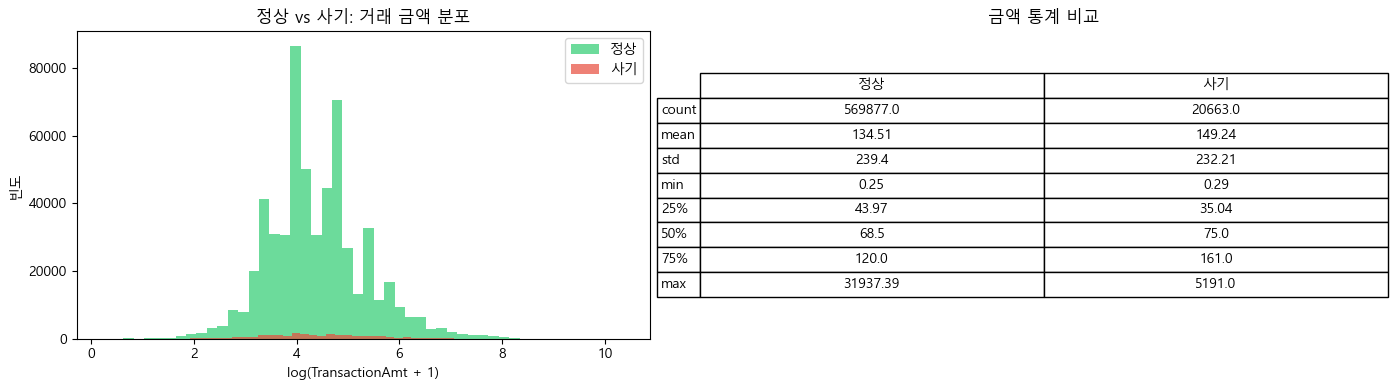

In [20]:
# 📚 정상 vs 사기: 금액 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 로그 금액 분포
df_normal = df[df['isFraud'] == 0]
df_fraud = df[df['isFraud'] == 1]

axes[0].hist(np.log1p(df_normal['TransactionAmt']), bins=50, alpha=0.7, label='정상', color='#2ecc71')
axes[0].hist(np.log1p(df_fraud['TransactionAmt']), bins=50, alpha=0.7, label='사기', color='#e74c3c')
axes[0].set_xlabel('log(TransactionAmt + 1)')
axes[0].set_ylabel('빈도')
axes[0].set_title('정상 vs 사기: 거래 금액 분포')
axes[0].legend()

# 금액 통계 비교
stats = pd.DataFrame({
    '정상': df_normal['TransactionAmt'].describe(),
    '사기': df_fraud['TransactionAmt'].describe()
})
axes[1].axis('off')
table = axes[1].table(cellText=stats.round(2).values,
                       rowLabels=stats.index,
                       colLabels=stats.columns,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1].set_title('금액 통계 비교')

plt.tight_layout()
plt.show()

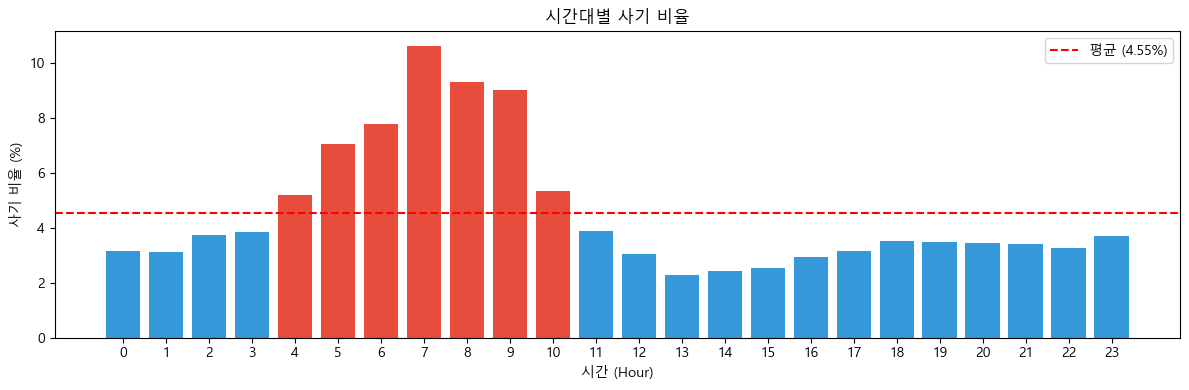

사기 비율 높은 시간대: 7시 (10.61%)
사기 비율 낮은 시간대: 13시 (2.29%)


In [21]:
# 📚 시간대별 사기 비율
fraud_by_hour = df.groupby('hour')['isFraud'].mean() * 100

plt.figure(figsize=(12, 4))
colors = ['#e74c3c' if x > fraud_by_hour.mean() else '#3498db' for x in fraud_by_hour]
plt.bar(fraud_by_hour.index, fraud_by_hour.values, color=colors)
plt.axhline(y=fraud_by_hour.mean(), color='red', linestyle='--', label=f'평균 ({fraud_by_hour.mean():.2f}%)')
plt.xlabel('시간 (Hour)')
plt.ylabel('사기 비율 (%)')
plt.title('시간대별 사기 비율')
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()

print(f"사기 비율 높은 시간대: {fraud_by_hour.idxmax()}시 ({fraud_by_hour.max():.2f}%)")
print(f"사기 비율 낮은 시간대: {fraud_by_hour.idxmin()}시 ({fraud_by_hour.min():.2f}%)")

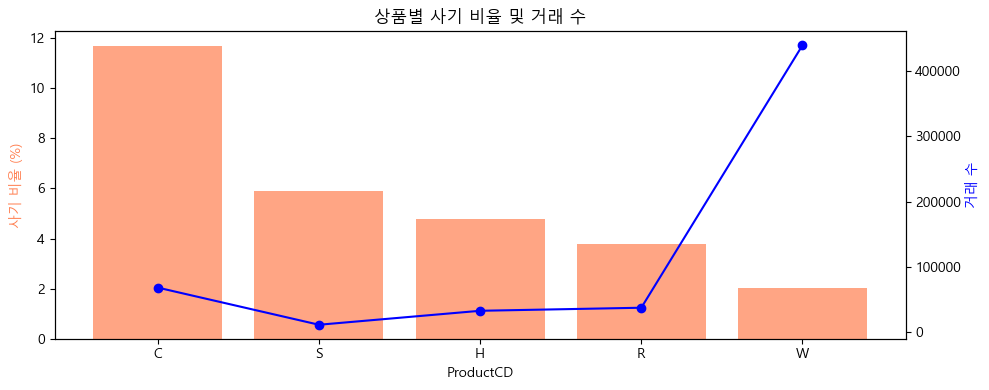

상품별 사기 비율:
            mean   count
ProductCD               
C          11.69   68519
S           5.90   11628
H           4.77   33024
R           3.78   37699
W           2.04  439670


In [22]:
# 📚 상품별 사기 비율
fraud_by_product = df.groupby('ProductCD')['isFraud'].agg(['mean', 'count'])
fraud_by_product['mean'] = fraud_by_product['mean'] * 100
fraud_by_product = fraud_by_product.sort_values('mean', ascending=False)

fig, ax1 = plt.subplots(figsize=(10, 4))

x = range(len(fraud_by_product))
ax1.bar(x, fraud_by_product['mean'], color='coral', alpha=0.7, label='사기 비율')
ax1.set_ylabel('사기 비율 (%)', color='coral')
ax1.set_xlabel('ProductCD')
ax1.set_xticks(x)
ax1.set_xticklabels(fraud_by_product.index)

ax2 = ax1.twinx()
ax2.plot(x, fraud_by_product['count'], 'bo-', label='거래 수')
ax2.set_ylabel('거래 수', color='blue')

plt.title('상품별 사기 비율 및 거래 수')
plt.tight_layout()
plt.show()

print("상품별 사기 비율:")
print(fraud_by_product.round(2).to_string())

---
## 7. 시간 기반 Train/Test 분할

### 7-1. 왜 시간 기반 분할인가?

**랜덤 분할의 문제:**
```
Train: [1월, 3월, 5월 거래]
Test:  [2월, 4월, 6월 거래]
→ 미래 정보가 학습에 포함 (Data Leakage)
→ 실제보다 과대평가된 성능
```

**시간 기반 분할:**
```
Train: [1월~4월 거래]  →  Test: [5월~6월 거래]
→ 실제 운영 환경과 동일
→ 현실적인 성능 평가
```

In [23]:
# 📚 시간순 정렬 및 분할
df_sorted = df.sort_values('TransactionDT').reset_index(drop=True)

# 80/20 분할
split_idx = int(len(df_sorted) * 0.8)
train_df = df_sorted.iloc[:split_idx].copy()
test_df = df_sorted.iloc[split_idx:].copy()

print(f"Train: {len(train_df):,}건 ({len(train_df)/len(df):.1%})")
print(f"Test:  {len(test_df):,}건 ({len(test_df)/len(df):.1%})")

print(f"\nTrain 기간: {train_df['datetime'].min()} ~ {train_df['datetime'].max()}")
print(f"Test 기간:  {test_df['datetime'].min()} ~ {test_df['datetime'].max()}")

Train: 472,432건 (80.0%)
Test:  118,108건 (20.0%)

Train 기간: 2017-12-02 00:00:00 ~ 2018-04-21 02:54:02
Test 기간:  2018-04-21 02:55:00 ~ 2018-06-01 23:58:51


In [24]:
# 📚 분할 검증: 시간 순서 확인
train_max = train_df['TransactionDT'].max()
test_min = test_df['TransactionDT'].min()

assert train_max <= test_min, "시간 순서 오류!"
print("✅ 검증 통과: Train 마지막 시점 < Test 첫 시점")

# 사기 비율 비교
print(f"\nTrain 사기 비율: {train_df['isFraud'].mean():.2%}")
print(f"Test 사기 비율:  {test_df['isFraud'].mean():.2%}")

✅ 검증 통과: Train 마지막 시점 < Test 첫 시점

Train 사기 비율: 3.51%
Test 사기 비율:  3.44%


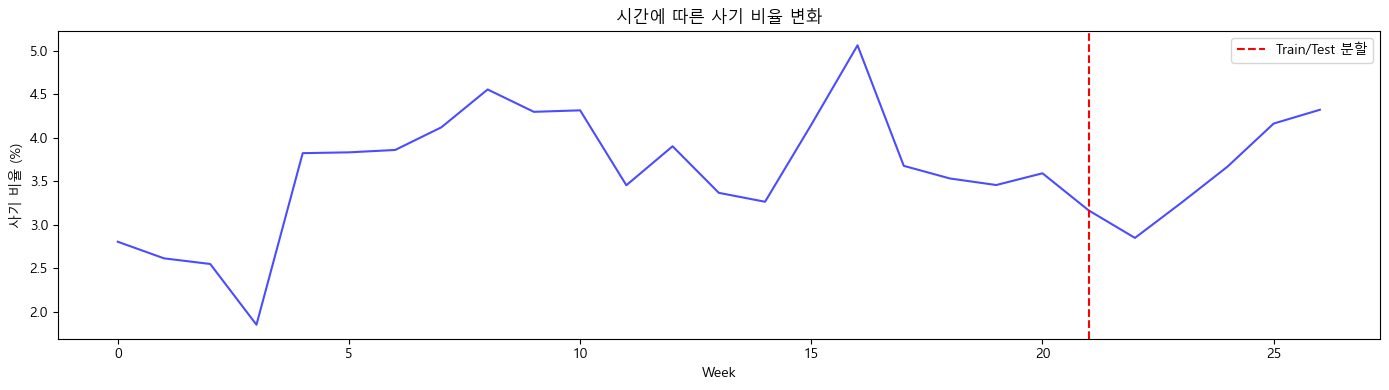

In [25]:
# 📚 시간에 따른 사기 비율 변화
df_sorted['week'] = (df_sorted['TransactionDT'] // (60*60*24*7)).astype(int)
fraud_by_week = df_sorted.groupby('week')['isFraud'].mean() * 100

plt.figure(figsize=(14, 4))
plt.plot(fraud_by_week.index, fraud_by_week.values, 'b-', alpha=0.7)
plt.axvline(x=fraud_by_week.index[int(len(fraud_by_week)*0.8)], color='red', linestyle='--', label='Train/Test 분할')
plt.xlabel('Week')
plt.ylabel('사기 비율 (%)')
plt.title('시간에 따른 사기 비율 변화')
plt.legend()
plt.tight_layout()
plt.show()

---
## 8. 데이터 저장

In [27]:
# 📚 임시 컬럼 제거 후 저장
cols_to_drop = ['datetime', 'hour', 'dayofweek', 'day', 'week']
cols_to_drop = [c for c in cols_to_drop if c in train_df.columns]

train_df_save = train_df.drop(columns=cols_to_drop)
test_df_save = test_df.drop(columns=cols_to_drop)

# 저장
train_df_save.to_csv(DATA_PROCESSED / 'train.csv', index=False)
test_df_save.to_csv(DATA_PROCESSED / 'test.csv', index=False)

print(f"저장 완료!")
print(f"  - {DATA_PROCESSED / 'train.csv'}")
print(f"  - {DATA_PROCESSED / 'test.csv'}")

저장 완료!
  - ..\..\data\processed\train.csv
  - ..\..\data\processed\test.csv


---
## 면접 Q&A

### Q: "불균형 데이터를 어떻게 처리했나요?"

> "IEEE-CIS 데이터는 사기 비율이 3.5%입니다. Accuracy 대신 AUC-ROC를 주 평가 지표로 사용했고, XGBoost의 scale_pos_weight 파라미터로 소수 클래스에 가중치를 줬습니다. SMOTE 같은 오버샘플링은 오히려 과적합을 유발해서 사용하지 않았습니다."

### Q: "왜 랜덤 분할이 아닌 시간 기반 분할을 하나요?"

> "실제 FDS는 과거 데이터로 학습해서 미래 거래를 예측합니다. 랜덤 분할은 미래 정보가 학습에 포함되어 Data Leakage가 발생합니다. 시간 기반 분할이 실제 운영 환경을 반영합니다."

### Q: "결측치가 많은데 어떻게 처리했나요?"

> "XGBoost는 결측치를 자동 처리합니다. 별도 대체 없이도 학습이 가능하고, 오히려 결측 자체가 정보일 수 있습니다. 결측 비율이 70% 이상인 컬럼은 정보 가치가 낮아 삭제를 고려했습니다."

---
## 최종 체크포인트

In [ ]:
print("=" * 60)
print("  1-1 완료: 데이터 로드 + EDA")
print("=" * 60)
print()
print("배운 것:")
print()
print("1. 데이터 구조")
print(f"   - Transaction + Identity LEFT JOIN")
print(f"   - 총 {len(df):,}건, {len(df.columns)}개 컬럼")
print()
print("2. 불균형 데이터")
print(f"   - 사기 비율: {df['isFraud'].mean():.2%}")
print(f"   - Accuracy 무의미, AUC-ROC 사용")
print()
print("3. 결측치")
print(f"   - 결측 있는 컬럼: {len(missing_pct)}개")
print(f"   - XGBoost 자동 처리 활용")
print()
print("4. 시간 기반 분할")
print(f"   - Train: {len(train_df):,}건 / Test: {len(test_df):,}건")
print(f"   - Data Leakage 방지")
print()
print("산출물:")
print(f"   - data/processed/train.csv")
print(f"   - data/processed/test.csv")
print()
print("=" * 60)
print("다음: 1-2 Feature Engineering")
print("=" * 60)